# Part 6, Model 3 NN: Glaucoma Detection using a neural network on the fundus, the optic cup, and the optic disk images of the eye + calculated OC feature + calculated OD feature + computed I-GRI (Integrated Glaucoma Risk Index) feature (predictive imputation used to fill up NaN values) using statistical analysis.

In [48]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

In [50]:
tf.__version__

'2.15.0'

In [51]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

fundus_subset = pd.read_csv('metadata - standardized.csv')

In [52]:
fundus_subset.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [53]:
fundus_subset.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
fundus_subset['fundus_oc_seg'].dtype

dtype('O')

In [55]:
fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [56]:
print(fundus_subset['fundus'][12044])
print(fundus_subset['fundus_oc_seg'][12044])
print(fundus_subset['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


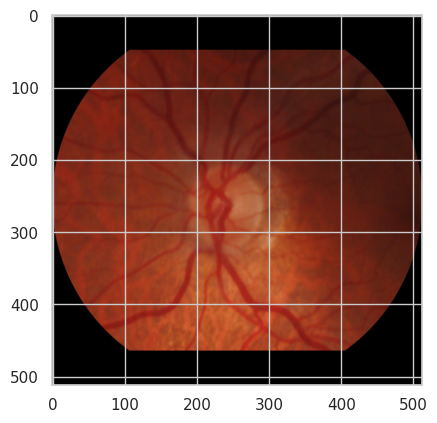

optic-cup/optic-cup/PAPILA-484.png


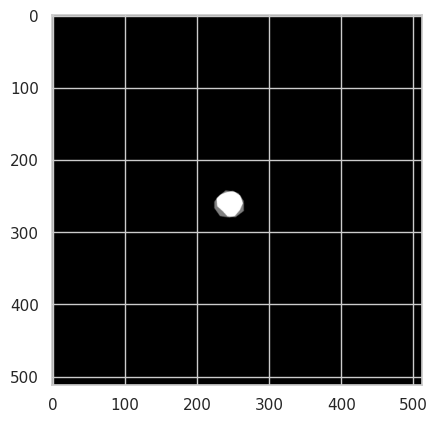

optic-disc/optic-disc/PAPILA-484.png


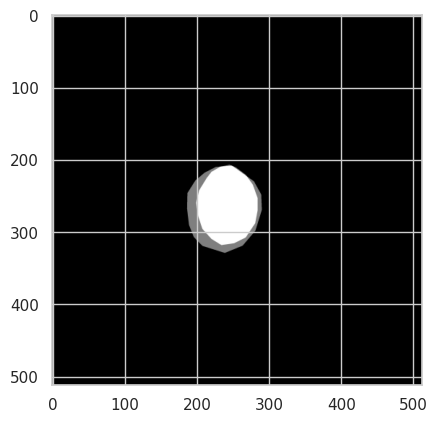

In [57]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()


viewFundus(fundus_subset['fundus'][12044])
viewOpticCup(fundus_subset['fundus_oc_seg'][12044])
viewOpticDisc(fundus_subset['fundus_od_seg'][12044])

In [58]:
fundus_subset.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [60]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

fundus_subset = fundus_subset.dropna(axis=1, how='all')

fundus_subset['eye'] = fundus_subset['eye'].replace({'OD': 0, 'OS': 1})

for col in ['gender', 'eye']:
    if col in fundus_subset.columns:
        mode = fundus_subset[col].mode()[0]
        fundus_subset[col] = fundus_subset[col].fillna(mode)

numerical_data = fundus_subset.select_dtypes(include=[np.number])

rf_regressor = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    n_jobs=-1,
    random_state=None
)

imp = IterativeImputer(
    estimator=rf_regressor,
    max_iter=10,
    random_state=None
)

numerical_data_imputed = imp.fit_transform(numerical_data)

numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

integer_columns = ['types', 'isColor', 'gender', 'eye', 'age']
for col in integer_columns:
    if col in numerical_data_imputed.columns:
        numerical_data_imputed[col] = numerical_data_imputed[col].round().astype('Int64')

non_numerical_data = fundus_subset.select_dtypes(exclude=[np.number])
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

data_imputed = data_imputed.loc[fundus_subset.index]

print("Shape of imputed data:", data_imputed.shape)

Shape of imputed data: (12449, 47)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [61]:
print(data_imputed.describe())

          types  isColor    gender        age       eye           sbp  \
count   12449.0  12449.0   12449.0    12449.0   12449.0  12449.000000   
mean   0.372239      1.0  0.985059  59.172142   0.77444    194.554884   
std    0.505039      0.0  0.121322   8.012112  0.417968     76.198992   
min        -1.0      1.0       0.0        1.0       0.0    107.000000   
25%         0.0      1.0       1.0       57.0       1.0    124.813333   
50%         0.0      1.0       1.0       62.0       1.0    145.380000   
75%         1.0      1.0       1.0       62.0       1.0    297.886667   
max         1.0      1.0       1.0       91.0       1.0    412.000000   

                dbp            hr           iop          vcdr  ...  \
count  12449.000000  12449.000000  12449.000000  12449.000000  ...   
mean      72.653743     64.038442     15.423049      0.580327  ...   
std        4.780525      3.348174      1.374321      0.115437  ...   
min       47.000000     51.000000      8.000000      0.161000 

In [62]:
data_imputed[["eye"]].value_counts()

eye
1      9641
0      2808
Name: count, dtype: int64

In [63]:
fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

In [64]:
fundus_subset = data_imputed

fundus_subset

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,0,1,1,58,0,299.886667,75.773333,62.793333,15.960000,0.392289,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1,60,1,139.153333,73.986667,63.413333,17.386667,0.599440,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,1,66,1,132.420000,79.040000,73.786667,17.100000,0.676954,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,1,70,0,143.626667,83.900000,74.126667,17.166667,0.661374,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,1,45,1,262.793333,72.926667,62.906667,16.446667,0.553512,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0,1,1,57,1,297.886667,75.846667,62.813333,15.946667,0.384477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0,1,1,57,1,297.886667,75.846667,62.813333,15.946667,0.384477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0,1,1,57,1,297.886667,75.846667,62.813333,15.946667,0.384477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0,1,1,57,1,297.886667,75.846667,62.813333,15.946667,0.384477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


optic-cup/optic-cup/PAPILA-484.png
optic-cup/optic-cup/PAPILA-484.png


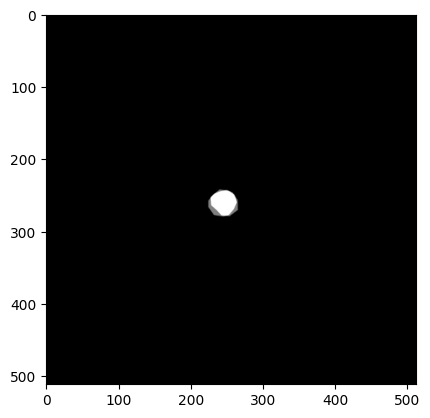

Normalized OC Area: 0.004856109619140625


optic-cup/optic-cup/PAPILA-484.png


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

def compute_normalized_area_optic_cup(masked_image_path):

    try:

        masked_image_path = 'optic-cup' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_cup(fundus_subset['fundus_oc_seg'][12044])

viewOpticCup(fundus_subset['fundus_oc_seg'][12044])

print(f"Normalized OC Area: {normalized_area}")

optic-disc/optic-disc/PAPILA-484.png
optic-disc/optic-disc/PAPILA-484.png


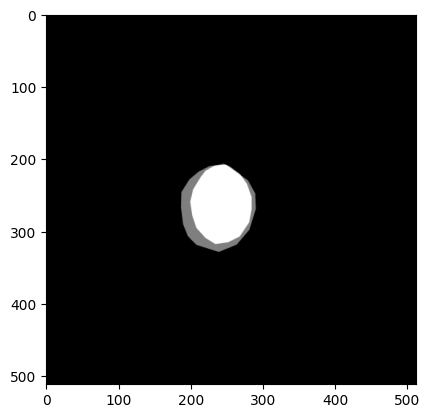

Normalized OD Area: 0.037567138671875


In [ ]:
import cv2
import numpy as np

def compute_normalized_area_optic_disc(masked_image_path):

    try:

        masked_image_path = 'optic-disc' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_disc(fundus_subset['fundus_od_seg'][12044])

viewOpticDisc(fundus_subset['fundus_od_seg'][12044])

print(f"Normalized OD Area: {normalized_area}")

In [ ]:
fundus_subset = fundus_subset [

    (fundus_subset['fundus'].notnull()) &
    (fundus_subset['fundus_oc_seg'].notnull()) & 
    (fundus_subset['fundus_od_seg'].notnull()) & (fundus_subset['types'] != -1)
]

fundus_subset = fundus_subset[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3034 entries, 4546 to 12048
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   types          3034 non-null   object 
 1   fundus         3034 non-null   object 
 2   fundus_oc_seg  3034 non-null   object 
 3   fundus_od_seg  3034 non-null   object 
 4   names          3034 non-null   object 
 5   gender         3034 non-null   Int64  
 6   age            3034 non-null   Int64  
 7   eye            3034 non-null   Int64  
 8   sbp            3034 non-null   float64
 9   dbp            3034 non-null   float64
 10  hr             3034 non-null   float64
 11  iop            3034 non-null   float64
 12  vcdr           3034 non-null   float64
 13  cdr_avg        3034 non-null   float64
 14  combined       3034 non-null   object 
dtypes: Int64(3), float64(6), object(6)
memory usage: 388.1+ KB


In [ ]:
fundus_subset['types'].value_counts()

types
0    2310
1     724
Name: count, dtype: int64

In [ ]:
fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']
fundus_subset = fundus_subset[fundus_subset['fundus_od_seg'] != 'Not Visible']
fundus_subset = fundus_subset[fundus_subset['fundus'] != 'Not Visible']

In [ ]:
import cv2
import numpy as np
import pandas as pd

fundus_subset['OC size'] = 0.0

for index, row in fundus_subset.iterrows():
    normalized_area = compute_normalized_area_optic_cup(row['fundus_oc_seg'])
    fundus_subset.at[index, 'OC size'] = normalized_area

optic-cup/optic-cup/ORIGA-1.png
optic-cup/optic-cup/ORIGA-2.png
optic-cup/optic-cup/ORIGA-3.png
optic-cup/optic-cup/ORIGA-4.png
optic-cup/optic-cup/ORIGA-5.png
optic-cup/optic-cup/ORIGA-6.png
optic-cup/optic-cup/ORIGA-7.png
optic-cup/optic-cup/ORIGA-8.png
optic-cup/optic-cup/ORIGA-9.png
optic-cup/optic-cup/ORIGA-10.png
optic-cup/optic-cup/ORIGA-11.png
optic-cup/optic-cup/ORIGA-12.png
optic-cup/optic-cup/ORIGA-13.png
optic-cup/optic-cup/ORIGA-14.png
optic-cup/optic-cup/ORIGA-15.png
optic-cup/optic-cup/ORIGA-16.png
optic-cup/optic-cup/ORIGA-17.png
optic-cup/optic-cup/ORIGA-18.png
optic-cup/optic-cup/ORIGA-19.png
optic-cup/optic-cup/ORIGA-20.png
optic-cup/optic-cup/ORIGA-21.png
optic-cup/optic-cup/ORIGA-22.png
optic-cup/optic-cup/ORIGA-23.png
optic-cup/optic-cup/ORIGA-24.png
optic-cup/optic-cup/ORIGA-25.png
optic-cup/optic-cup/ORIGA-26.png
optic-cup/optic-cup/ORIGA-27.png
optic-cup/optic-cup/ORIGA-28.png
optic-cup/optic-cup/ORIGA-29.png
optic-cup/optic-cup/ORIGA-30.png
optic-cup/optic-cup

In [ ]:
import cv2
import numpy as np
import pandas as pd

fundus_subset['OD size'] = 0.0  

for index, row in fundus_subset.iterrows():
    normalized_area = compute_normalized_area_optic_disc(row['fundus_od_seg'])
    fundus_subset.at[index, 'OD size'] = normalized_area

optic-disc/optic-disc/ORIGA-1.png
optic-disc/optic-disc/ORIGA-2.png
optic-disc/optic-disc/ORIGA-3.png
optic-disc/optic-disc/ORIGA-4.png
optic-disc/optic-disc/ORIGA-5.png
optic-disc/optic-disc/ORIGA-6.png
optic-disc/optic-disc/ORIGA-7.png
optic-disc/optic-disc/ORIGA-8.png
optic-disc/optic-disc/ORIGA-9.png
optic-disc/optic-disc/ORIGA-10.png
optic-disc/optic-disc/ORIGA-11.png
optic-disc/optic-disc/ORIGA-12.png
optic-disc/optic-disc/ORIGA-13.png
optic-disc/optic-disc/ORIGA-14.png
optic-disc/optic-disc/ORIGA-15.png
optic-disc/optic-disc/ORIGA-16.png
optic-disc/optic-disc/ORIGA-17.png
optic-disc/optic-disc/ORIGA-18.png
optic-disc/optic-disc/ORIGA-19.png
optic-disc/optic-disc/ORIGA-20.png
optic-disc/optic-disc/ORIGA-21.png
optic-disc/optic-disc/ORIGA-22.png
optic-disc/optic-disc/ORIGA-23.png
optic-disc/optic-disc/ORIGA-24.png
optic-disc/optic-disc/ORIGA-25.png
optic-disc/optic-disc/ORIGA-26.png
optic-disc/optic-disc/ORIGA-27.png
optic-disc/optic-disc/ORIGA-28.png
optic-disc/optic-disc/ORIGA-2

In [ ]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size
4546,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1,88,0,147.606667,78.320000,76.060000,16.606667,0.709700,0.757233,ORIGA-1.png,0.010849,0.022560
4547,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1,88,1,149.093333,78.746667,75.866667,16.573333,0.695300,0.757217,ORIGA-2.png,0.010250,0.020405
4548,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1,87,1,149.000000,78.320000,75.720000,16.700000,0.962900,0.761900,ORIGA-3.png,0.019222,0.020947
4549,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1,89,0,148.000000,78.153333,76.193333,16.673333,0.724600,0.757517,ORIGA-4.png,0.008072,0.015347
4550,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1,71,1,144.633333,89.413333,75.706667,18.666667,0.613800,0.711417,ORIGA-5.png,0.008331,0.018131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,0,64,1,130.746667,88.140000,73.733333,18.520000,0.615628,0.708167,PAPILA-484.png,0.004856,0.037567
12045,0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,1,75,1,147.866667,89.886667,75.920000,18.680000,0.630984,0.724033,PAPILA-485.png,0.004936,0.039188
12046,0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,0,55,1,252.420000,86.220000,72.293333,18.860000,0.565286,0.547517,PAPILA-486.png,0.002399,0.024658
12047,0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,1,56,1,254.360000,86.100000,71.993333,18.706667,0.545689,0.581500,PAPILA-487.png,0.006138,0.028481


## I-GRI Calculation

In [ ]:
selected_features = ['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']

In [ ]:
fundus_subset = fundus_subset.reset_index(drop=True)

fundus_subset.head()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size
0,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1,88,0,147.606667,78.320000,76.060000,16.606667,0.7097,0.757233,ORIGA-1.png,0.010849,0.022560
1,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1,88,1,149.093333,78.746667,75.866667,16.573333,0.6953,0.757217,ORIGA-2.png,0.010250,0.020405
2,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1,87,1,149.000000,78.320000,75.720000,16.700000,0.9629,0.761900,ORIGA-3.png,0.019222,0.020947
3,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1,89,0,148.000000,78.153333,76.193333,16.673333,0.7246,0.757517,ORIGA-4.png,0.008072,0.015347
4,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1,71,1,144.633333,89.413333,75.706667,18.666667,0.6138,0.711417,ORIGA-5.png,0.008331,0.018131


In [ ]:
from scipy.spatial import distance

def getNNI(row_number):

    dataUM = fundus_subset[selected_features]

    instance = dataUM.iloc[row_number]

    distances = dataUM.apply(lambda row: distance.euclidean(row, instance), axis=1)

    nearest_indices = distances.nsmallest(5 + 1).index

    nearest_indices = nearest_indices.drop(row_number)

    nni = ( dataUM.loc[nearest_indices].loc[fundus_subset['types'] == 1].shape[0] ) / 5

    return nni

In [29]:
fundus_subset['NNI'] = fundus_subset.apply(lambda row: getNNI(row.name), axis=1)

In [30]:
fundus_subset.head()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI
0,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1,88,0,147.606667,78.320000,76.060000,16.606667,0.7097,0.757233,ORIGA-1.png,0.010849,0.022560,0.0
1,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1,88,1,149.093333,78.746667,75.866667,16.573333,0.6953,0.757217,ORIGA-2.png,0.010250,0.020405,0.0
2,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1,87,1,149.000000,78.320000,75.720000,16.700000,0.9629,0.761900,ORIGA-3.png,0.019222,0.020947,0.0
3,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1,89,0,148.000000,78.153333,76.193333,16.673333,0.7246,0.757517,ORIGA-4.png,0.008072,0.015347,0.0
4,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1,71,1,144.633333,89.413333,75.706667,18.666667,0.6138,0.711417,ORIGA-5.png,0.008331,0.018131,0.0


In [31]:
for column in selected_features:
    fundus_subset[column] = (fundus_subset[column] - fundus_subset[column].min()) / (fundus_subset[column].max() - fundus_subset[column].min())

weights = {
    'gender': 0.05,
    'age': 0.1,
    'eye': 0.05,
    'sbp': 0.08,
    'dbp': 0.08,
    'hr': 0.05,
    'iop': 0.15,
    'vcdr': 0.15,
    'cdr_avg': 0.15,
    'OC_size': 0.14,
    'OD_size': 0.16
}

fundus_subset['I-GRI'] = np.sum(fundus_subset[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']] * list(weights.values()),axis=1)

In [32]:
fundus_subset[['types', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'NNI', 'I-GRI']].head()

,types,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,NNI,I-GRI
0,0,1.0,0.96875,0.0,0.118322,0.585699,0.921003,0.749099,0.684250,0.766050,0.272610,0.322588,0.0,0.668936
1,0,1.0,0.96875,1.0,0.125763,0.599780,0.913184,0.745494,0.666293,0.766021,0.257007,0.277283,0.0,0.707595
2,0,1.0,0.953125,1.0,0.125296,0.585699,0.907253,0.759193,1.000000,0.774273,0.490757,0.288670,0.0,0.792468
3,0,1.0,0.984375,0.0,0.120291,0.580198,0.926395,0.756309,0.702831,0.766549,0.200258,0.170957,0.0,0.640039
4,0,1.0,0.703125,1.0,0.103440,0.951815,0.906713,0.971882,0.564659,0.685316,0.207016,0.229492,0.0,0.699048


In [33]:
fundus_subset['final_I-GRI'] = fundus_subset['I-GRI'] * 0.8 + fundus_subset['NNI'] * 0.2

In [34]:
fundus_subset.head()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
0,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1.0,0.96875,0.0,0.118322,0.585699,0.921003,0.749099,0.684250,0.766050,ORIGA-1.png,0.272610,0.322588,0.0,0.668936,0.535149
1,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1.0,0.96875,1.0,0.125763,0.599780,0.913184,0.745494,0.666293,0.766021,ORIGA-2.png,0.257007,0.277283,0.0,0.707595,0.566076
2,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1.0,0.953125,1.0,0.125296,0.585699,0.907253,0.759193,1.000000,0.774273,ORIGA-3.png,0.490757,0.288670,0.0,0.792468,0.633974
3,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1.0,0.984375,0.0,0.120291,0.580198,0.926395,0.756309,0.702831,0.766549,ORIGA-4.png,0.200258,0.170957,0.0,0.640039,0.512031
4,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1.0,0.703125,1.0,0.103440,0.951815,0.906713,0.971882,0.564659,0.685316,ORIGA-5.png,0.207016,0.229492,0.0,0.699048,0.559239


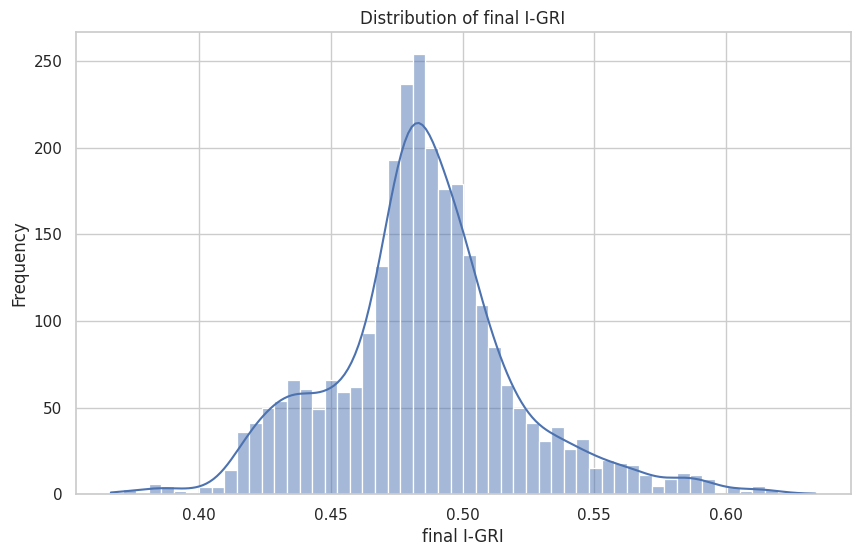

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(fundus_subset['final_I-GRI'], kde=True)

plt.title('Distribution of final I-GRI')
plt.xlabel('final I-GRI')
plt.ylabel('Frequency')

plt.show()

In [36]:
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.10
val_percentage_from_train = 0.05

class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(fundus_subset['types']),
                y=fundus_subset['types'].values)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

print("\nTotal fundus images to be used:", len(fundus_subset))
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

print("\nClass weights for model training:")
print(class_weights_dict)

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140

Total fundus images to be used: 2805

Train set size: 2397
Validation set size: 127
Test set size: 281

Class weights for model training:
{0: 0.655373831775701, 1: 2.1090225563909772}


In [37]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  2397
Test Size:  281


In [38]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-03 22:38:50.333442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:38:50.756124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:38:50.756559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [39]:
train

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
303,1,/full-fundus/ORIGA-304.png,/optic-cup/ORIGA-304.png,/optic-disc/ORIGA-304.png,ORIGA-304,1.0,0.640625,1.0,0.062331,0.949615,0.943920,0.890411,0.569522,0.702907,ORIGA-304.png,0.161499,0.194932,0.0,0.670439,0.536351
541,0,/full-fundus/ORIGA-542.png,/optic-cup/ORIGA-542.png,/optic-disc/ORIGA-542.png,ORIGA-542,1.0,0.421875,0.0,0.538690,0.845765,0.754651,0.994232,0.544332,0.414860,ORIGA-542.png,0.104949,0.118515,0.0,0.567345,0.453876
1775,0,/full-fundus/G1020-237.png,/optic-cup/G1020-237.png,/optic-disc/G1020-237.png,G1020-237,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,G1020-237.png,0.064103,0.250982,0.0,0.608703,0.486963
506,1,/full-fundus/ORIGA-507.png,/optic-cup/ORIGA-507.png,/optic-disc/ORIGA-507.png,ORIGA-507,1.0,0.5625,0.0,0.003103,0.677008,0.940415,0.547224,0.815064,0.746549,ORIGA-507.png,0.216557,0.155160,0.0,0.579149,0.463319
39,0,/full-fundus/ORIGA-40.png,/optic-cup/ORIGA-40.png,/optic-disc/ORIGA-40.png,ORIGA-40,1.0,0.796875,1.0,0.141713,0.822882,0.897277,0.770728,0.599451,0.749163,ORIGA-40.png,0.093421,0.099270,0.0,0.648583,0.518866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,0,/full-fundus/REFUGE1-val-398.png,/optic-cup/REFUGE1-val-398.png,/optic-disc/REFUGE1-val-398.png,REFUGE1-val-398,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,REFUGE1-val-398.png,0.276983,0.420175,0.0,0.665577,0.532462
308,0,/full-fundus/ORIGA-309.png,/optic-cup/ORIGA-309.png,/optic-disc/ORIGA-309.png,ORIGA-309,1.0,0.421875,0.0,0.576829,0.845985,0.757886,0.998558,0.512408,0.383407,ORIGA-309.png,0.106937,0.109294,0.0,0.560521,0.448417
113,0,/full-fundus/ORIGA-114.png,/optic-cup/ORIGA-114.png,/optic-disc/ORIGA-114.png,ORIGA-114,1.0,0.5,1.0,0.663385,0.844664,0.756808,0.899784,0.396808,0.521615,ORIGA-114.png,0.117770,0.205838,0.0,0.630637,0.50451
2538,0,/full-fundus/PAPILA-186.png,/optic-cup/PAPILA-186.png,/optic-disc/PAPILA-186.png,PAPILA-186,1.0,0.828125,0.0,0.126130,0.925853,0.892424,0.927181,0.580033,0.699060,PAPILA-186.png,0.016498,0.492583,0.0,0.673656,0.538925


In [40]:
val

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
2143,0,/full-fundus/G1020-714.png,/optic-cup/G1020-714.png,/optic-disc/G1020-714.png,G1020-714,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,G1020-714.png,0.050189,0.384171,0.0,0.628066,0.502453
1988,0,/full-fundus/G1020-502.png,/optic-cup/G1020-502.png,/optic-disc/G1020-502.png,G1020-502,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,G1020-502.png,0.050487,0.117072,0.0,0.585372,0.468297
633,1,/full-fundus/ORIGA-634.png,/optic-cup/ORIGA-634.png,/optic-disc/ORIGA-634.png,ORIGA-634,1.0,0.46875,1.0,0.825987,0.854125,0.658938,0.719539,0.439830,0.549280,ORIGA-634.png,0.107434,0.218667,0.0,0.620556,0.496445
2599,1,/full-fundus/PAPILA-254.png,/optic-cup/PAPILA-254.png,/optic-disc/PAPILA-254.png,PAPILA-254,1.0,0.53125,1.0,0.054623,0.849945,0.852791,0.564528,0.573259,0.707841,PAPILA-254.png,0.326873,0.418170,0.0,0.657644,0.526115
1260,0,/full-fundus/REFUGE1-val-66.png,/optic-cup/REFUGE1-val-66.png,/optic-disc/REFUGE1-val-66.png,REFUGE1-val-66,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,REFUGE1-val-66.png,0.113198,0.227889,0.0,0.611882,0.489505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0,/full-fundus/DRISHTI-GS1-train-3.png,/optic-cup/DRISHTI-GS1-train-3.png,/optic-disc/DRISHTI-GS1-train-3.png,DRISHTI-GS1-train-3,1.0,0.4375,1.0,0.735560,0.848405,0.662982,0.953136,0.468887,0.440529,DRISHTI-GS1-train-3.png,0.330650,0.386256,0.0,0.691091,0.552873
2022,0,/full-fundus/G1020-547.png,/optic-cup/G1020-547.png,/optic-disc/G1020-547.png,G1020-547,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,G1020-547.png,0.223117,0.343116,0.0,0.645707,0.516565
908,0,/full-fundus/REFUGE1-train-259.png,/optic-cup/REFUGE1-train-259.png,/optic-disc/REFUGE1-train-259.png,REFUGE1-train-259,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,REFUGE1-train-259.png,0.103061,0.120359,0.0,0.593258,0.474606
1058,1,/full-fundus/CRFO-v4-10.png,/optic-cup/CRFO-v4-10.png,/optic-disc/CRFO-v4-10.png,CRFO-v4-10,1.0,0.5625,1.0,0.004071,0.381298,0.554058,0.423216,0.644181,0.796916,CRFO-v4-10.png,0.242894,0.137840,0.0,0.550489,0.440391


In [41]:
test

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
2750,1,/full-fundus/PAPILA-432.png,/optic-cup/PAPILA-432.png,/optic-disc/PAPILA-432.png,PAPILA-432,1.0,0.6875,1.0,0.153092,0.097690,0.040712,0.322999,0.617091,0.895066,PAPILA-432.png,0.135957,0.596584,0.0,0.580609,0.464487
1427,0,/full-fundus/REFUGE1-val-233.png,/optic-cup/REFUGE1-val-233.png,/optic-disc/REFUGE1-val-233.png,REFUGE1-val-233,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,REFUGE1-val-233.png,0.127211,0.294203,0.0,0.624454,0.499563
2142,0,/full-fundus/G1020-713.png,/optic-cup/G1020-713.png,/optic-disc/G1020-713.png,G1020-713,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,G1020-713.png,0.081097,0.218106,0.0,0.605822,0.484658
1075,0,/full-fundus/CRFO-v4-50.png,/optic-cup/CRFO-v4-50.png,/optic-disc/CRFO-v4-50.png,CRFO-v4-50,1.0,0.46875,0.0,0.587207,0.850825,0.759234,0.984859,0.488526,0.447283,CRFO-v4-50.png,0.144902,0.223238,0.0,0.593984,0.475187
20,0,/full-fundus/ORIGA-21.png,/optic-cup/ORIGA-21.png,/optic-disc/ORIGA-21.png,ORIGA-21,1.0,0.09375,1.0,0.642931,0.846425,0.768671,0.992790,0.500187,0.262614,ORIGA-21.png,0.186047,0.243605,0.0,0.595319,0.476255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,0,/full-fundus/REFUGE1-train-255.png,/optic-cup/REFUGE1-train-255.png,/optic-disc/REFUGE1-train-255.png,REFUGE1-train-255,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,REFUGE1-train-255.png,0.147784,0.254992,0.0,0.62106,0.496848
1214,0,/full-fundus/REFUGE1-val-20.png,/optic-cup/REFUGE1-val-20.png,/optic-disc/REFUGE1-val-20.png,REFUGE1-val-20,1.0,0.515625,1.0,0.663385,0.844664,0.756808,0.899784,0.230530,0.533186,REFUGE1-val-20.png,0.086166,0.202710,0.0,0.604069,0.483255
208,0,/full-fundus/ORIGA-209.png,/optic-cup/ORIGA-209.png,/optic-disc/ORIGA-209.png,ORIGA-209,1.0,0.5,1.0,0.767126,0.837184,0.746832,0.899784,0.414391,0.516211,ORIGA-209.png,0.120254,0.166627,0.0,0.63374,0.506992
2460,0,/full-fundus/PAPILA-105.png,/optic-cup/PAPILA-105.png,/optic-disc/PAPILA-105.png,PAPILA-105,1.0,0.59375,0.0,0.045347,0.875468,0.771097,0.932949,0.524040,0.663642,PAPILA-105.png,0.007454,0.416085,0.0,0.607307,0.485845


In [42]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-04-03 22:38:50.920025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:38:50.920883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:38:50.921783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:38:51.510135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:38:51.512106: I external/local_xla/xla/stream_executor

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [43]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [44]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=False, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [45]:
def combined_generator(generators, num_features, labels, batch_size):
    while True:

        images_batch = [next(gen)[0] for gen in generators]
        
        idx = (generators[0].batch_index - 1) * generators[0].batch_size
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))
        
        num_features_batch = np.array(num_features[batch_index], dtype=np.float32)
        
        labels_batch = np.array(labels[batch_index], dtype=np.float32)

        yield images_batch + [num_features_batch], labels_batch

num_features = train[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'final_I-GRI']].astype(np.float32).values
labels = train['types'].values.astype(np.float32)

train_generator = combined_generator(
    [trainGen1, trainGen2, trainGen3],
    num_features,
    labels,
    batchSize
)

val_features = val[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'final_I-GRI']].astype(np.float32).values
val_labels = val['types'].values.astype(np.float32)

val_generator = combined_generator(
    [valGen1, valGen2, valGen3],
    val_features,
    val_labels,
    batchSize
)

test_features = test[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'final_I-GRI']].astype(np.float32).values
test_labels = test['types'].values.astype(np.float32)

test_generator = combined_generator(
    [testGen1, testGen2, testGen3],
    test_features,
    test_labels,
    batchSize
)


In [46]:
mock_batch_data, mock_batch_labels = next(train_generator)

print("Image batch shape:", mock_batch_data[0].shape)
print("Image batch shape:", mock_batch_data[1].shape)
print("Image batch shape:", mock_batch_data[2].shape)
print("Numerical batch shape:", mock_batch_data[3].shape)
print("Label batch shape:", mock_batch_labels.shape)

Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Numerical batch shape: (1, 12)
Label batch shape: (1,)


In [47]:
mock_batch_data, mock_batch_labels = next(test_generator)

print("Image batch shape:", mock_batch_data[0].shape)
print("Image batch shape:", mock_batch_data[1].shape)
print("Image batch shape:", mock_batch_data[2].shape)
print("Numerical batch shape:", mock_batch_data[3].shape)
print("Label batch shape:", mock_batch_labels.shape)

Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Numerical batch shape: (1, 12)
Label batch shape: (1,)


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate

image_input_shape = (224, 224, 3)
num_features = 12

fundus_input = Input(shape=image_input_shape, name='fundus_input')
optic_cup_input = Input(shape=image_input_shape, name='optic_cup_input')
optic_disc_input = Input(shape=image_input_shape, name='optic_disc_input')

num_features_input = Input(shape=(num_features,), name='numerical_input')

def simple_cnn(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return x

fundus_features = simple_cnn(fundus_input)
optic_cup_features = simple_cnn(optic_cup_input)
optic_disc_features = simple_cnn(optic_disc_input)

combined_features = concatenate([fundus_features, optic_cup_features, optic_disc_features, num_features_input])

x = Dense(256, activation='relu')(combined_features)
x = Dense(128, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[fundus_input, optic_cup_input, optic_disc_input, num_features_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fundus_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 optic_cup_input (InputLaye  [(None, 224, 224, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 optic_disc_input (InputLay  [(None, 224, 224, 3)]        0         []                            
 er)                                                                                              
                                                                                            

: 

In [ ]:
from keras.utils import model_to_dot
from IPython.display import Image

dot = model_to_dot(
    model,
    show_shapes=True,
    show_layer_names=False,
    rankdir='TB',
    dpi=200
)

for n in dot.get_nodes():

    n.set('style', 'filled')
    n.set('fillcolor', '#D9E2DF')
    n.set('fontname', 'Helvetica')

for e in dot.get_edges():

    e.set('color', '#42473F')
    e.set('arrowsize', '1.2')

dot.set_graph_defaults(
    bgcolor='#FFFFFF',
    pad='0.5',
    ranksep='1.0',
    nodesep='0.5'
)
dot.set_node_defaults(
    shape='box',
    style='filled',
    fillcolor='#D9E2DF',
    height='0.5',
    width='0.5',
    fontsize='10',
    color='#666666'
)
dot.set_edge_defaults(
    color='#D9E2DF',
    arrowsize='0.8',
    fontsize='10'
)

dot.write_png('architectures/model_3_Architecture.png')
Image('architectures/model_3_Architecture.png')

In [86]:
history = model.fit(
    
    x=train_generator,
    epochs=10,
    steps_per_epoch=len(trainGen1),
    validation_data=val_generator,
    validation_steps=len(valGen1),
    class_weight=class_weights_dict
)

Epoch 1/10


2397/2397 [==============================] - 65s 25ms/step - loss: 2.3781 - accuracy: 0.7526 - val_loss: 0.1918 - val_accuracy: 0.9449
Epoch 2/10
2397/2397 [==============================] - 64s 27ms/step - loss: 0.1832 - accuracy: 0.9516 - val_loss: 0.1073 - val_accuracy: 0.9685
Epoch 3/10
2397/2397 [==============================] - 69s 29ms/step - loss: 0.0857 - accuracy: 0.9779 - val_loss: 0.0857 - val_accuracy: 0.9843
Epoch 4/10
2397/2397 [==============================] - 65s 27ms/step - loss: 0.0556 - accuracy: 0.9862 - val_loss: 0.0771 - val_accuracy: 0.9843
Epoch 5/10
2397/2397 [==============================] - 65s 27ms/step - loss: 0.0458 - accuracy: 0.9866 - val_loss: 0.0701 - val_accuracy: 0.9843
Epoch 6/10
2397/2397 [==============================] - 68s 28ms/step - loss: 0.1899 - accuracy: 0.9729 - val_loss: 0.0584 - val_accuracy: 0.9843
Epoch 7/10
2397/2397 [==============================] - 64s 27ms/step - loss: 0.0420 - accuracy: 0.9896 - val_loss: 0.0583 - val_accura

In [87]:
batchSize = 1 

def generate_evaluation_batches(image_gens, num_features, batch_size):

    while True:

        batches = [gen.next() for gen in image_gens]
        image_batches = [batch[0].astype(np.float32) for batch in batches]
        
        idx = (image_gens[0].batch_index - 1) * batch_size
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))

        yield image_batches + [num_features[batch_index]], batches[0][1]


val_evaluation_generator = generate_evaluation_batches([valGen1, valGen2, valGen3], val_features, 1)

test_evaluation_generator = generate_evaluation_batches([testGen1, testGen2, testGen3], test_features, 1)

val_steps = len(val) // batchSize
test_steps = len(test) // batchSize

val_loss, val_accuracy = model.evaluate(val_evaluation_generator, steps=val_steps)
print('Validation accuracy:', val_accuracy)

test_loss, test_accuracy = model.evaluate(test_evaluation_generator, steps=test_steps)
print('Test accuracy:', test_accuracy)

127/127 [==============================] - 3s 27ms/step - loss: 0.0619 - accuracy: 0.9764
Validation accuracy: 0.9763779640197754
281/281 [==============================] - 8s 28ms/step - loss: 0.0275 - accuracy: 0.9858
Test accuracy: 0.9857650995254517


In [89]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_generator, steps=len(testGen1))
predicted_classes = (predictions > 0.5).astype(int).flatten()

actual_labels = []
for _, labels in test_evaluation_generator:
    actual_labels.extend(labels)
    if len(actual_labels) >= len(testGen1) * batchSize:
        break

actual_labels = np.array(actual_labels)[:len(predicted_classes)]

report = classification_report(actual_labels, predicted_classes)
print(report)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels, predicted_classes)
print(conf_matrix)

281/281 [==============================] - 6s 23ms/step
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77       214
         1.0       0.25      0.24      0.24        67

    accuracy                           0.64       281
   macro avg       0.51      0.50      0.50       281
weighted avg       0.64      0.64      0.64       281

[[165  49]
 [ 51  16]]
